# Notebook - Análise da evasão

Dados do Instituto de Ciências Exatas (IE).

### Importando bibliotecas:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

import utils
import pre_process

%matplotlib inline

 ### Leitura dos dados

In [2]:
DATA_FILE = '../data/ie_data.csv'
data_pre = pd.read_csv(DATA_FILE, sep=';', low_memory=False)

## Pré-Processamento

In [3]:
attrs = []
data_pre = pre_process.format_data(data_pre)
data_pre = pre_process.erase_attr(data_pre)
data_pre = data_pre.dropna()

data_pre = pre_process.public_school(data_pre, attrs)
# data_pre = pre_process.credits(data_pre, attrs)
data_pre = pre_process.dropout(data_pre, attrs)
data_pre = pre_process.course(data_pre, attrs)
data_pre = pre_process.gender(data_pre, attrs)
data_pre = pre_process.quota(data_pre, attrs)
data_pre = pre_process.entry(data_pre, attrs)
# data_pre = pre_process.ira(data_pre, attrs)
# data_pre = pre_process.programming_subjects(data_pre, attrs)

In [4]:
data_pre['course'].unique()

array(['ciência da computação', 'computação', 'engenharia de computação',
       'engenharia elétrica', 'engenharia florestal',
       'engenharia mecânica', 'engenharia mecatrônica', 'estatística',
       'matemática', 'engenharia civil'], dtype=object)

In [5]:
data_course = pre_process.divide_course(data_pre)

Process CEP

Cep needs to be processed before drop_duplicates, otherwise it takes too long to process.

In [ ]:
# Cep needs to be processed before drop_duplicates,
# otherwise it takes too long to process.
data_pre = data_pre[attrs+['cep']].drop_duplicates()
data_pre = pre_process.cep(data_pre, attrs)

In [ ]:
data_pre = data_pre[attrs].drop_duplicates()
data_process = data_pre.copy()

## Testes Mecatrônica

In [10]:
meca = data_course['engenharia elétrica']

In [11]:
meca['nome_disciplina'].value_counts()[:20]

introducao a ciencia da computacao    2165
principios de comunicacao              153
circuitos polifasicos                  132
circuitos eletricos 2                  130
introducao a algebra linear            123
variavel complexa 1                    121
fisica 1                               120
calculo 3                              119
fenomenos de transporte                117
eletronica                             116
calculo 2                              116
materiais eletricos e magneticos       115
introducao a economia                  115
eletromagnetismo 1                     114
fisica 1 experimental                  112
probabilidade e estatistica            112
introducao a mecanica dos solidos      109
fisica 2                               109
quimica geral experimental             109
introducao a sociologia                109
Name: nome_disciplina, dtype: int64

In [9]:
meca = pre_process.subjects(meca, attrs)

In [10]:
meca = meca[attrs+['cep']].drop_duplicates()

In [11]:
meca = pre_process.cep(meca, attrs)

In [12]:
data_process = meca[attrs].drop_duplicates()

In [ ]:
data_process.columns

In [ ]:
data_process.shape

## Processamento

In [13]:

output_attr = 'dropout'
X = data_process.drop(columns=[output_attr])
y = data_process[output_attr]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

model = CatBoostClassifier()
model.fit(X_train, y_train, cat_features=['course', 'entry'], plot=True)

predicts = model.predict(X_test)
predicts = [x == 'True' for x in predicts]
print('Accuracy score:', accuracy_score(y_test, predicts))
print('Recall score:', recall_score(y_test, predicts))
print('Precision score:', precision_score(y_test, predicts))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.011894
0:	learn: 0.6880915	total: 51.1ms	remaining: 51s
1:	learn: 0.6828171	total: 53.9ms	remaining: 26.9s
2:	learn: 0.6780521	total: 56.4ms	remaining: 18.7s
3:	learn: 0.6732021	total: 59.3ms	remaining: 14.8s
4:	learn: 0.6685644	total: 61.7ms	remaining: 12.3s
5:	learn: 0.6642125	total: 64.4ms	remaining: 10.7s
6:	learn: 0.6597618	total: 66.8ms	remaining: 9.48s
7:	learn: 0.6553939	total: 69.1ms	remaining: 8.57s
8:	learn: 0.6509368	total: 71.3ms	remaining: 7.85s
9:	learn: 0.6467952	total: 73.6ms	remaining: 7.29s
10:	learn: 0.6421590	total: 75.8ms	remaining: 6.81s
11:	learn: 0.6376111	total: 78ms	remaining: 6.42s
12:	learn: 0.6343326	total: 79.8ms	remaining: 6.06s
13:	learn: 0.6313127	total: 81ms	remaining: 5.71s
14:	learn: 0.6276647	total: 82.6ms	remaining: 5.42s
15:	learn: 0.6242646	total: 84.4ms	remaining: 5.19s
16:	learn: 0.6221324	total: 86.1ms	remaining: 4.98s
17:	learn: 0.6189910	total: 88.3ms	remaining: 4.82s
18:	learn: 0.6172353	total: 89.5ms	remaining: 4.62

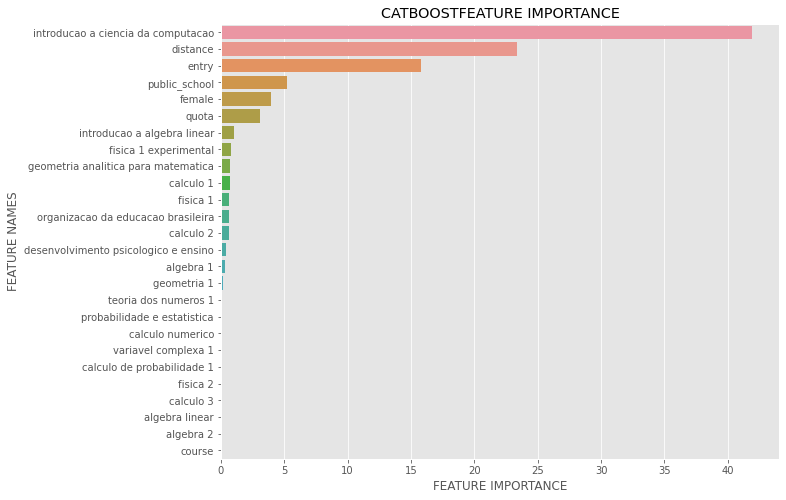

In [14]:
def plot_feature_importance(importance,names,model_type):
    plt.style.use('ggplot')
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(model.get_feature_importance(), X.columns,'CATBOOST')

In [16]:
y_train.value_counts()

True     1030
False     370
Name: dropout, dtype: int64

## Using SHAP

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
start_index = 0
end_index = 1000
shap_values = explainer.shap_values(X_test[start_index:end_index])

In [ ]:
shap.initjs()

In [ ]:
id = 4
shap.force_plot(explainer.expected_value,
                shap_values[id:id+1],
                X_test[id:id+1])

In [ ]:
shap.force_plot(explainer.expected_value,
                shap_values,
                X_test[start_index:end_index])

In [ ]:
shap.summary_plot(shap_values, X[start_index:end_index], plot_size=(20,20))

In [ ]:
shap.dependence_plot('programming_subject', shap_values, X_test[start_index:end_index], interaction_index='distance')

In [ ]:
shap.summary_plot(shap_values, X_test[start_index:end_index])

## Plot Student's House Coordinates

In [ ]:
attr = ['aluno', 'cep', 'dropout', 'course']
data_map = data_analysis.copy()[attr].drop_duplicates()
data_map_course = pre_process.divide_course(data_map)

utils.plot_coordinates(data_map, 'all courses')
for course, data_course in data_map_course.items():
    utils.plot_coordinates(data_course, course)

In [ ]:
x = []
y = []
c = []
coordinate_json = utils.read_json('../data/coordinate.json')
attr = 'cep'

for index, row in data_map.iterrows():
    cep = str(row[attr])
    info = coordinate_json[cep]
    if info['lat'] < -17:
        data_map.drop(index, inplace=True)
        continue
    x.append(info['lat'])
    y.append(-info['lng'])
    c.append('red' if row['dropout'] else 'blue')

In [ ]:
sns.displot(data_map, x=x, y=y, hue='dropout', height=6)

In [ ]:
p = sns.jointplot(data=data_map,x=x, y=y,kind='kde')

In [ ]:
sns.kdeplot(x=x,y=y,hue=c,
            shade=True,
            thresh=False
)